# Bigram Language Modeling using frequency counts for generating Onion-like News Headlines

Based on Andrej Karpathy's first half Youtube lecture [The spelled-out intro to language modeling: building makemore](https://www.youtube.com/watch?v=PaCmpygFfXo)

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

import pdb, sys, warnings, os, json, torch, re, string
warnings.filterwarnings(action='ignore')

from IPython.display import display, HTML
from pathlib import Path


import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
%matplotlib inline

seed = 2468975301
unk_pct = 5

## Functions

In [2]:
def plot_top_words(ax, bigram_word_counts, top_n=20):
  df = pd.DataFrame(bigram_word_counts.most_common(n=top_n), columns=['Bigram', 'Counts'])
  sns.barplot(data=df, y='Bigram', x='Counts', ax=ax)

## Data Setup

In [3]:
try:
  onion_df = pd.read_csv('../../data/cleaned_onion_headlines.csv')
except FileNotFoundError:
  onion_df = pd.read_csv('../../data/original_onion_headlines.csv')

  onion_df['text'] = onion_df['text'].str.encode('ascii', 'ignore').str.decode('ascii')
  onion_df['text'] = onion_df['text'].apply(str.lower)

  onion_df['text'] = onion_df['text'].apply(lambda t: re.sub(r'\$([0-9]+)', '\g<1> dollars', t))

  from num2words import num2words
  def convert_nums(text):
    nums = re.findall(r'\d+', text)
    converts = {num: num2words(num).replace('-', ' ') for num in nums}
    for num,word in converts.items():
      text = text.replace(num, word)
    return text
  onion_df['text'] = onion_df['text'].apply(convert_nums)

  onion_df['text'] = onion_df['text'].apply(lambda t: re.sub(r'[^a-z ]', '', t))
  onion_df['text'].replace('', np.nan, inplace=True)
  onion_df.dropna(inplace=True)
  onion_df.to_csv('../../data/cleaned_onion_headlines.csv', index=None)
onion_df.shape

(14362, 1)

In [4]:
onion_df['length'] = onion_df['text'].apply(lambda t: len(t.split()))
onion_df['length'].describe()

count    14362.000000
mean        12.787077
std          5.495774
min          1.000000
25%          9.000000
50%         12.000000
75%         16.000000
max         53.000000
Name: length, dtype: float64

In [5]:
idx = 0
text = onion_df.iloc[idx]['text']
print(text)

entire facebook staff laughs as man tightens privacy settings


In [6]:
idx = np.random.randint(len(onion_df))
text = onion_df.iloc[idx]['text']
print(text)

realistic day planner only includes first couple weeks after purchase


## Bigram Language Model

Spring random `<u>` tokens to induce its counts artificially. In the test set this token will be used to refer to OOV tokens. Also add `<s>` at the start and end for special tokens

In [7]:
texts = onion_df['text'].tolist()
rng = np.random.default_rng(seed)
for i,text in enumerate(texts):  
  if rng.random() <= (unk_pct/100):
    tokens = text.split()
    tokens.insert(rng.integers(0, len(tokens)), '<u>')
    texts[i] = ' '.join(tokens)
  texts[i] = f'<s> {texts[i]} <s>'

In [8]:
vocab = sorted(set(' '.join(texts).split()))
vocab_size = len(vocab)
stoi = {s:i for i,s in enumerate(vocab)}
itos = {i:s for i,s in enumerate(vocab)}
print(vocab_size)

21754


In [9]:
bigram_idx_counts = torch.zeros(len(stoi), len(stoi), dtype=torch.int32)
bigram_word_counts = Counter()

for text in texts:
  words = text.split()
  for word1, word2 in zip(words, words[1:]):
    idx1 = stoi[word1]
    idx2 = stoi[word2]
    bigram_idx_counts[idx1, idx2] += 1
    bigram_word_counts[f'{word1} {word2}'] += 1

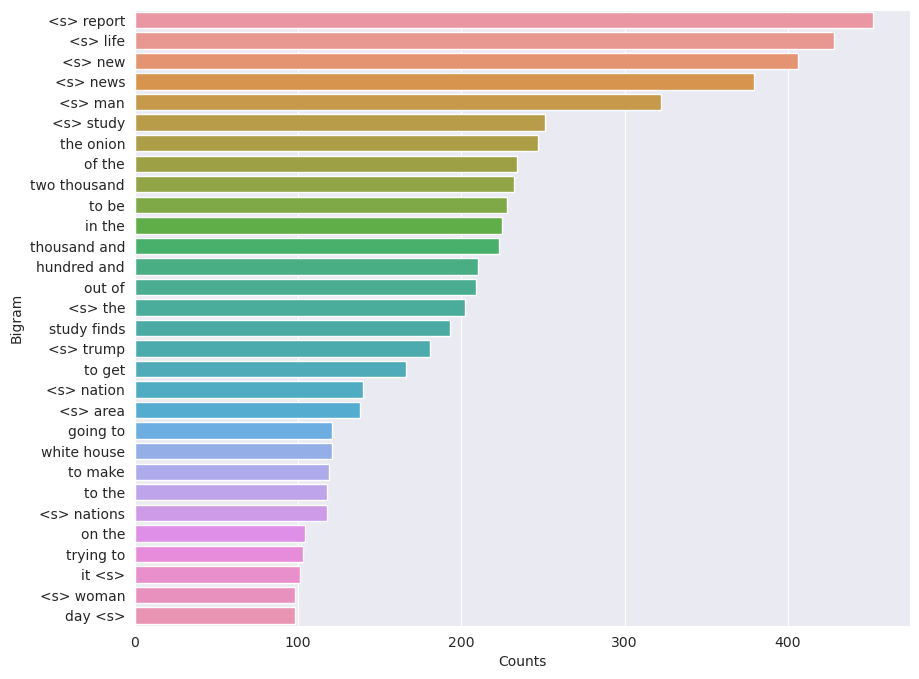

In [10]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
plot_top_words(ax, bigram_word_counts, top_n=30)

In [11]:
bigram_idx_counts[0]

tensor([ 0, 72, 41,  ...,  0,  0,  0], dtype=torch.int32)

In [12]:
idx = np.random.randint(len(bigram_idx_counts))
p = bigram_idx_counts[idx].float()/bigram_idx_counts[idx].sum()
p

tensor([0.2353, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000])

In [13]:
bigram_probs = bigram_idx_counts.float()/bigram_idx_counts.sum(axis=1, keepdim=True)

In [14]:
bigram_probs[idx] == p

tensor([True, True, True,  ..., True, True, True])

In [15]:
g = torch.Generator().manual_seed(seed)
idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[idx]

'testing'

In [16]:
g = torch.Generator().manual_seed(seed)
n_headlines = 20
for _ in range(n_headlines):
  print('*'*50)
  idx = 0
  ai_onion = []
  while True:
    idx = torch.multinomial(bigram_probs[idx], num_samples=1, replacement=True, generator=g).item()
    # idx = torch.multinomial(torch.ones(vocab_size))/vocab_size), num_samples=1, replacement=True, generator=g).item()
    ai_onion.append(itos[idx])
    if idx == 0:
      break
  print(' '.join(ai_onion[:-1]))    

**************************************************
scientists warn ionosphere one dollars
**************************************************
cooking together on crutches walking the time if you need to get cats can you need a ball boys who felt board adopts second girl to ensure he promised waaay too sad enough to mix just finished a psfour feature scans everything whimpers rick harrison ford had oil executives marvel as going to hunt for caring <u> in fathers soul in the works
**************************************************
alqaedas no instructions immediately
**************************************************
doubleentendre doesnt win this bucktoothed gorilla that isnt one tells him story
**************************************************
man to become annoying mom could have sex trafficking allegations of engine just getting bored too even more money
**************************************************
michael flynns face of civilization
********************************************

GOAL: Maximize the liklihood of the data w.r.t model parameters (statistical modeling). This is equivalent to:
1. maximizing the log liklihood (because log is monotonic)
2. minimizing the negative log liklihood
3. minimizing the average negative logliklihood

In [17]:
log_likelihood = 0.
n = 0
for text in texts:
  words = text.split()
  for word1, word2 in zip(words, words[1:]):
    idx1 = stoi[word1]
    idx2 = stoi[word2]
    prob = torch.max(bigram_probs[idx1, idx2], torch.tensor(1/vocab_size))
    logprob = torch.log(prob)
    log_likelihood += logprob
    # print(f"{word1} {word2}: {prob:0.4f} {logprob:0.4f}")
    n += 1

print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")    
print(f"average nll {nll/n:0.4f}")

log_likelihood=tensor(-709293.8125)
nll=tensor(709293.8125)
average nll 3.5687


In [18]:
cnn_headline = 'Trump goes to Supreme Court over Mar a Lago search and seizure of documents'.lower()
onion_headline = 'High Schoolers Given Detention For Cutting Class During Active Shooting'.lower()

In [19]:
log_likelihood = 0.
n = 0
for text in [cnn_headline]:
  words = ['<s>'] + text.split() + ['<s>']
  for word1, word2 in zip(words, words[1:]):
    if word1 not in vocab:
      word1 = '<u>'
    if word2 not in vocab:
      word2 = '<u>'
    idx1 = stoi[word1]
    idx2 = stoi[word2]
    prob = torch.max(bigram_probs[idx1, idx2], torch.tensor(vocab_size))
    logprob = torch.log(prob)
    log_likelihood += logprob
    # print(f"{word1} {word2}: {prob:0.4f} {logprob:0.4f}")
    n += 1

print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")    
print(f"average nll {nll/n:0.4f}")

log_likelihood=tensor(149.8133)
nll=tensor(-149.8133)
average nll -9.9876


In [20]:
log_likelihood = 0.
n = 0
for text in [onion_headline]:
  words = ['<s>'] + text.split() + ['<s>']
  for word1, word2 in zip(words, words[1:]):
    if word1 not in vocab:
      word1 = '<u>'
    if word2 not in vocab:
      word2 = '<u>'
    idx1 = stoi[word1]
    idx2 = stoi[word2]
    prob = torch.max(bigram_probs[idx1, idx2], torch.tensor(vocab_size))
    logprob = torch.log(prob)
    log_likelihood += logprob
    # print(f"{word1} {word2}: {prob:0.4f} {logprob:0.4f}")
    n += 1

print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")    
print(f"average nll {nll/n:0.4f}")

log_likelihood=tensor(109.8631)
nll=tensor(-109.8631)
average nll -9.9876
